# Deeplabcut analysis

## Step 1: Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import zipfile
import umap
import scipy.io
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Step 2: Load the Data

In [3]:
path_to_extracted_folder = 'D:/deeplabcut/'
data_files = os.listdir(path_to_extracted_folder)
saline_files = [file for file in data_files if any(mouse in file for mouse in ['322', '328', '330', '332'])]
pfa_files = [file for file in data_files if any(mouse in file for mouse in ['326', '327', '334', '335', '336'])]

saline_dataframes = [pd.read_csv('D:/deeplabcut/' + file, header=[1,2]) for file in saline_files]
pfa_dataframes = [pd.read_csv('D:/deeplabcut/' + file, header=[1,2]) for file in pfa_files]

In [4]:
saline_files

['322DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '322_salDLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '328DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '328_salDLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '330DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '330_salDLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '332DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '332_salDLC_resnet50_SP_behaviorOct10shuffle1_800000.csv']

In [5]:
pfa_files

['326DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '326_PFADLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '327DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '327_PFADLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '334DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '334_PFADLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '335DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '335_PFADLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '336DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv',
 '336_PFADLC_resnet50_SP_behaviorOct10shuffle1_800000.csv']

In [6]:
saline_dataframes_cropped = saline_dataframes
pfa_dataframes_cropped = pfa_dataframes

In [7]:
frame_info_df_manual = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_led_frames.csv')

In [8]:
for f in range(len(saline_dataframes)):
    shape = saline_dataframes_cropped[f].shape[0]
    print(f"The number of rows in saline_dataframes[{f}] is {shape}")


The number of rows in saline_dataframes[0] is 64368
The number of rows in saline_dataframes[1] is 54470
The number of rows in saline_dataframes[2] is 60105
The number of rows in saline_dataframes[3] is 56312
The number of rows in saline_dataframes[4] is 67886
The number of rows in saline_dataframes[5] is 62965
The number of rows in saline_dataframes[6] is 61075
The number of rows in saline_dataframes[7] is 57337


In [9]:
for f in range(len(pfa_dataframes)):
    shape = pfa_dataframes_cropped[f].shape[0]
    print(f"The number of rows in pfa_dataframes[{f}] is {shape}")

The number of rows in pfa_dataframes[0] is 56475
The number of rows in pfa_dataframes[1] is 55362
The number of rows in pfa_dataframes[2] is 55763
The number of rows in pfa_dataframes[3] is 54637
The number of rows in pfa_dataframes[4] is 59808
The number of rows in pfa_dataframes[5] is 55038
The number of rows in pfa_dataframes[6] is 60014
The number of rows in pfa_dataframes[7] is 54855
The number of rows in pfa_dataframes[8] is 65294
The number of rows in pfa_dataframes[9] is 60233


### data cropping to keep 54000 frames in each session

In [10]:
def crop_dataframe(df, file_name):
    # Extract the mouse name from the filename, stripping extensions or additional characters if needed
    mouse_name = file_name.split('DLC')[0].rstrip('_')
    start_frame = frame_info_df_manual[frame_info_df_manual['Filename'] == mouse_name]['Start'].values[0]
    return df.iloc[start_frame : start_frame + 54000]

saline_dataframes_cropped = [crop_dataframe(df, file) for df, file in zip(saline_dataframes, saline_files)]
pfa_dataframes_cropped = [crop_dataframe(df, file) for df, file in zip(pfa_dataframes, pfa_files)]


## Step 3: Data Cleaning

In [11]:
def clean_data_modified(df):
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # Replace missing values or NaN with interpolation on the copy
    df_copy.interpolate(method='linear', inplace=True, limit_direction='both')
    
    return df_copy

# Applying the modified function to the cropped dataframes
saline_dataframes_cleaned = [clean_data_modified(df) for df in saline_dataframes_cropped]
pfa_dataframes_cleaned = [clean_data_modified(df) for df in pfa_dataframes_cropped]


In [12]:
# List of specified body parts
body_parts = ['head', 'leftEar', 'rightEar', 'centerofMass', 'leftHip', 'rightHip', 'tailRoot']

def compute_center_coordinates(df):
    # Extracting x and y coordinates for the specified body parts
    x_coords = df.loc[:, pd.IndexSlice[body_parts, 'x']]
    y_coords = df.loc[:, pd.IndexSlice[body_parts, 'y']]
    
    # Computing average x and y coordinates across the body parts for each frame
    df['center_x'] = x_coords.median(axis=1)
    df['center_y'] = y_coords.median(axis=1)
    
    return df

# Applying the function to all dataframes in both conditions
saline_dataframes = [compute_center_coordinates(df) for df in saline_dataframes_cleaned]
pfa_dataframes = [compute_center_coordinates(df) for df in pfa_dataframes_cleaned]

saline_dataframes = [df.reset_index(drop=True) for df in saline_dataframes]
pfa_dataframes = [df.reset_index(drop=True) for df in pfa_dataframes]


# Checking the first few rows of the first dataframe in the saline condition to verify the new columns
saline_dataframes[0].head()


bodyparts miniscope_head                              snout               
     coords              x           y likelihood           x           y   
0      8576     841.260864  387.321960        1.0  862.359436  411.826202  \
1      8577     841.587097  387.586060        1.0  862.536377  411.923431   
2      8578     841.517151  387.464447        1.0  862.768555  411.958893   
3      8579     841.517090  387.465393        1.0  862.769287  411.958740   
4      8580     841.205139  387.916412        1.0  862.668884  412.120514   

                    head                         ...    tailRoot              
  likelihood           x           y likelihood  ...           y likelihood   
0   0.999712  875.362610  407.254944   0.999780  ...  389.657593   0.999991  \
1   0.999674  875.405762  407.328094   0.999792  ...  389.696228   0.999991   
2   0.999681  875.378113  407.393158   0.999802  ...  389.685394   0.999991   
3   0.999680  875.377502  407.393402   0.999802  ...  389.685486   0.999991   
4   0.999746  874.814392  407.451691   0.999786  ...  389.743561   0.999991   

      tailMid                            tailEnd                          
            x           y likelihood           x           y likelihood   
0  957.450745  330.619751   0.999948  959.282715  273.440857   0.999993  \
1  957.493896  330.628113   0.999947  959.305481  273.525452   0.999993   
2  957.498108  330.615387   0.999947  959.270630  273.461548   0.999993   
3  957.497864  330.613434   0.999947  959.269531  273.456726   0.999993   
4  957.490417  330.765564   0.999949  959.300720  273.823761   0.999993   

     center_x    center_y  
                           
0  911.807312  407.254944  
1  911.765747  407.328094  
2  911.791870  407.393158  
3  911.791870  407.393402  
4  911.842163  407.451691  

[5 rows x 39 columns]

In [13]:
saline_dataframes

[      bodyparts miniscope_head                              snout               
          coords              x           y likelihood           x           y   
 0          8576     841.260864  387.321960   1.000000  862.359436  411.826202  \
 1          8577     841.587097  387.586060   1.000000  862.536377  411.923431   
 2          8578     841.517151  387.464447   1.000000  862.768555  411.958893   
 3          8579     841.517090  387.465393   1.000000  862.769287  411.958740   
 4          8580     841.205139  387.916412   1.000000  862.668884  412.120514   
 ...         ...            ...         ...        ...         ...         ...   
 53995     62571     606.464539  173.683258   0.999996  626.430115  181.122467   
 53996     62572     608.818787  173.399139   0.999998  627.686279  183.489471   
 53997     62573     608.818420  173.398346   0.999998  627.685852  183.490509   
 53998     62574     612.314514  172.308624   0.999999  627.811279  182.697037   
 53999     62575

In [14]:
len(saline_dataframes_cleaned)


8

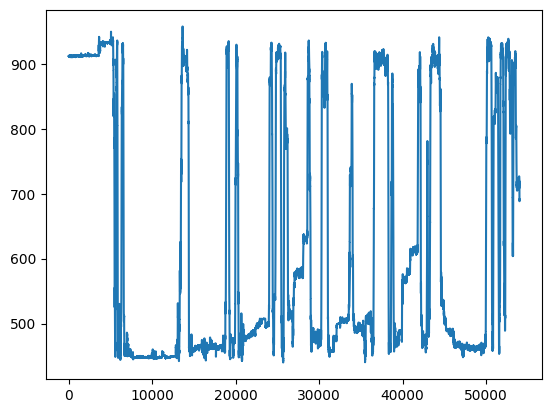

In [15]:
plt.plot(saline_dataframes[0]['center_x'])


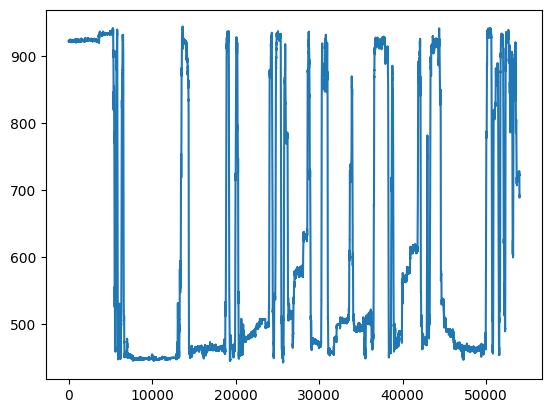

In [16]:
plt.plot(saline_dataframes[0]['centerofMass']['x'])

In [17]:
saline_dataframes[0]['center_x'].shape

(54000,)

## Behavior box center calculation

In [18]:
df_box = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_box_ccordinates.csv')

In [19]:
df_box

mouse_NO.  top_left_x  top_left_y  top_right_x  top_right_y   
0        322         430         172          962          180  \
1    322_sal         433         174          967          180   
2        326         429         175          961          177   
3    326_pfa         426         178          959          184   
4        327         432         173          966          181   
5    327_pfa         425         172          959          181   
6        328         427         169          962          182   
7    328_sal         427         172          961          179   
8        330         429         174          962          180   
9    330_sal         427         177          961          184   
10       332         428         174          962          182   
11   332_sal         430         176          962          184   
12       334         429         174          964          182   
13   334_pfa         427         175          961          184   
14       335         428         173          962          180   
15   335_pfa         427         176          960          184   
16       336         428         175          962          180   
17   336_pfa         398         142          932          142   

    bottom_right_x  bottom_right_y  bottom_left_x  bottom_left_y  
0              954             442            422            434  
1              964             441            430            435  
2              958             439            426            437  
3              953             445            420            439  
4              958             441            424            433  
5              954             443            420            434  
6              955             444            420            431  
7              954             441            420            434  
8              959             442            426            436  
9              956             446            422            439  
10             957             444            423            436  
11             955             444            423            436  
12             956             444            421            436  
13             953             445            419            436  
14             954             442            420            435  
15             954             446            421            438  
16             959             441            425            436  
17             928             403            394            403

In [20]:
def calculate_center(row):
    box_center_x = (row['top_left_x'] + row['top_right_x'] + row['bottom_right_x'] + row['bottom_left_x']) / 4
    box_center_y = (row['top_left_y'] + row['top_right_y'] + row['bottom_right_y'] + row['bottom_left_y']) / 4
    return box_center_x, box_center_y

df_box['box_center_x'], df_box['box_center_y'] = zip(*df_box.apply(calculate_center, axis=1))


In [21]:
def adjust_coordinates(row):
    # Calculate width and length of the box
    width = row['top_right_x'] - row['top_left_x']
    length = row['bottom_left_y'] - row['top_left_y']
    
    # Calculate the center of the box
    center_x = (row['top_left_x'] + row['top_right_x'] + row['bottom_right_x'] + row['bottom_left_x']) / 4
    center_y = (row['top_left_y'] + row['top_right_y'] + row['bottom_right_y'] + row['bottom_left_y']) / 4
    
    # Adjust coordinates if aspect ratio isn't met
    if length != 2 * width:
        width = width
        length = 2 * width
        row['top_left_x'] = center_x - width / 2
        row['top_right_x'] = center_x + width / 2
        row['bottom_left_x'] = center_x - width / 2
        row['bottom_right_x'] = center_x + width / 2
        row['top_left_y'] = center_y - length / 2
        row['top_right_y'] = center_y - length / 2
        row['bottom_left_y'] = center_y + length / 2
        row['bottom_right_y'] = center_y + length / 2

    return row

# Adjusting the coordinates in df_box
df_box_adjusted = df_box.apply(adjust_coordinates, axis=1)


In [22]:
# Load the CSV data
df_box_coordinates = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_box_ccordinates.csv')

def compute_sub_rectangles(row):
    # Extract coordinates
    tl = np.array([row['top_left_x'], row['top_left_y']])
    tr = np.array([row['top_right_x'], row['top_right_y']])
    br = np.array([row['bottom_right_x'], row['bottom_right_y']])
    bl = np.array([row['bottom_left_x'], row['bottom_left_y']])
    
    # Calculate the vectors representing the sides
    top_vector = (tr - tl) / 8
    bottom_vector = (br - bl) / 8
    left_vector = (bl - tl) / 4
    right_vector = (br - tr) / 4
    
    sub_rects = []
    
    for i in range(4):
        for j in range(8):
            # Calculate the vertices of each sub-rectangle
            sub_tl = tl + j * top_vector + i * left_vector
            sub_tr = sub_tl + top_vector
            sub_bl = sub_tl + left_vector
            sub_br = sub_bl + top_vector
            
            sub_rects.append({
                'mouse_NO.': row['mouse_NO.'],
                'top_left_x': sub_tl[0],
                'top_left_y': sub_tl[1],
                'top_right_x': sub_tr[0],
                'top_right_y': sub_tr[1],
                'bottom_right_x': sub_br[0],
                'bottom_right_y': sub_br[1],
                'bottom_left_x': sub_bl[0],
                'bottom_left_y': sub_bl[1],
            })
    
    return sub_rects

# Compute sub-rectangles for all rows
all_sub_rectangles = []
for _, row in df_box_coordinates.iterrows():
    all_sub_rectangles.extend(compute_sub_rectangles(row))

# Convert results to DataFrame
df_sub_rectangles = pd.DataFrame(all_sub_rectangles)

df_sub_rectangles.head()
df_sub_rectangles.to_csv

<bound method NDFrame.to_csv of     mouse_NO.  top_left_x  top_left_y  top_right_x  top_right_y   
0         322      430.00      172.00       496.50       173.00  \
1         322      496.50      173.00       563.00       174.00   
2         322      563.00      174.00       629.50       175.00   
3         322      629.50      175.00       696.00       176.00   
4         322      696.00      176.00       762.50       177.00   
..        ...         ...         ...          ...          ...   
571   336_pfa      595.25      337.75       662.00       337.75   
572   336_pfa      662.00      337.75       728.75       337.75   
573   336_pfa      728.75      337.75       795.50       337.75   
574   336_pfa      795.50      337.75       862.25       337.75   
575   336_pfa      862.25      337.75       929.00       337.75   

     bottom_right_x  bottom_right_y  bottom_left_x  bottom_left_y  
0            494.50           238.5         428.00          237.5  
1            561.00        

In [23]:
df_sub_rectangles

mouse_NO.  top_left_x  top_left_y  top_right_x  top_right_y   
0         322      430.00      172.00       496.50       173.00  \
1         322      496.50      173.00       563.00       174.00   
2         322      563.00      174.00       629.50       175.00   
3         322      629.50      175.00       696.00       176.00   
4         322      696.00      176.00       762.50       177.00   
..        ...         ...         ...          ...          ...   
571   336_pfa      595.25      337.75       662.00       337.75   
572   336_pfa      662.00      337.75       728.75       337.75   
573   336_pfa      728.75      337.75       795.50       337.75   
574   336_pfa      795.50      337.75       862.25       337.75   
575   336_pfa      862.25      337.75       929.00       337.75   

     bottom_right_x  bottom_right_y  bottom_left_x  bottom_left_y  
0            494.50           238.5         428.00          237.5  
1            561.00           239.5         494.50          238.5  
2            627.50           240.5         561.00          239.5  
3            694.00           241.5         627.50          240.5  
4            760.50           242.5         694.00          241.5  
..              ...             ...            ...            ...  
571          661.00           403.0         594.25          403.0  
572          727.75           403.0         661.00          403.0  
573          794.50           403.0         727.75          403.0  
574          861.25           403.0         794.50          403.0  
575          928.00           403.0         861.25          403.0  

[576 rows x 9 columns]

In [24]:
# Convert 'mouse_NO.' column to string type
df_sub_rectangles['mouse_NO.'] = df_sub_rectangles['mouse_NO.'].astype(str)

# Filter the dataframe based on mouse name containing specific strings
saline_group = df_sub_rectangles[df_sub_rectangles['mouse_NO.'].str.contains('322|328|330|332')]
pfa_group = df_sub_rectangles[df_sub_rectangles['mouse_NO.'].str.contains('326|327|334|335|336')]

# Re-index the two new dataframes
saline_group = saline_group.reset_index(drop=True)
pfa_group = pfa_group.reset_index(drop=True)

# Display the first few rows of each group
print(saline_group.head())
print(pfa_group.head())


  mouse_NO.  top_left_x  top_left_y  top_right_x  top_right_y  bottom_right_x   
0       322       430.0       172.0        496.5        173.0           494.5  \
1       322       496.5       173.0        563.0        174.0           561.0   
2       322       563.0       174.0        629.5        175.0           627.5   
3       322       629.5       175.0        696.0        176.0           694.0   
4       322       696.0       176.0        762.5        177.0           760.5   

   bottom_right_y  bottom_left_x  bottom_left_y  
0           238.5          428.0          237.5  
1           239.5          494.5          238.5  
2           240.5          561.0          239.5  
3           241.5          627.5          240.5  
4           242.5          694.0          241.5  
  mouse_NO.  top_left_x  top_left_y  top_right_x  top_right_y  bottom_right_x   
0       326       429.0      175.00        495.5       175.25          494.75  \
1       326       495.5      175.25        562.0   

In [25]:
saline_group['mouse_NO.']

0          322
1          322
2          322
3          322
4          322
        ...   
251    332_sal
252    332_sal
253    332_sal
254    332_sal
255    332_sal
Name: mouse_NO., Length: 256, dtype: object

In [26]:
pfa_group['mouse_NO.']

0          326
1          326
2          326
3          326
4          326
        ...   
315    336_pfa
316    336_pfa
317    336_pfa
318    336_pfa
319    336_pfa
Name: mouse_NO., Length: 320, dtype: object

In [27]:
df_sub_rectangles

mouse_NO.  top_left_x  top_left_y  top_right_x  top_right_y   
0         322      430.00      172.00       496.50       173.00  \
1         322      496.50      173.00       563.00       174.00   
2         322      563.00      174.00       629.50       175.00   
3         322      629.50      175.00       696.00       176.00   
4         322      696.00      176.00       762.50       177.00   
..        ...         ...         ...          ...          ...   
571   336_pfa      595.25      337.75       662.00       337.75   
572   336_pfa      662.00      337.75       728.75       337.75   
573   336_pfa      728.75      337.75       795.50       337.75   
574   336_pfa      795.50      337.75       862.25       337.75   
575   336_pfa      862.25      337.75       929.00       337.75   

     bottom_right_x  bottom_right_y  bottom_left_x  bottom_left_y  
0            494.50           238.5         428.00          237.5  
1            561.00           239.5         494.50          238.5  
2            627.50           240.5         561.00          239.5  
3            694.00           241.5         627.50          240.5  
4            760.50           242.5         694.00          241.5  
..              ...             ...            ...            ...  
571          661.00           403.0         594.25          403.0  
572          727.75           403.0         661.00          403.0  
573          794.50           403.0         727.75          403.0  
574          861.25           403.0         794.50          403.0  
575          928.00           403.0         861.25          403.0  

[576 rows x 9 columns]

In [28]:
import pickle

# Specify the path to your pickle file
file_path = 'indice_pfa.pickle'

# Open the file in binary read mode
with open(file_path, 'rb') as file:
    # Load the data from the file
    indice_pfa = pickle.load(file)

# Specify the path to your pickle file
file_path = 'indice_sal.pickle'

# Open the file in binary read mode
with open(file_path, 'rb') as file:
    # Load the data from the file
    indice_sal = pickle.load(file)

In [29]:
def rotate_points(points, angle, center):
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    translated_points = points - center
    rotated_points = rotation_matrix @ translated_points.T
    return rotated_points.T + center

def is_point_inside_rotated_rect(points, rect_coords):
    # Calculate the center and angle of the rectangle
    center = np.mean(rect_coords, axis=0)
    angle = np.arctan2(rect_coords[1, 1] - rect_coords[0, 1], rect_coords[1, 0] - rect_coords[0, 0])
    
    # Rotate points and rectangle to align with the axes
    rotated_points = rotate_points(points, -angle, center)
    rotated_rect = rotate_points(rect_coords, -angle, center)
    
    # Check if points are inside the aligned rectangle
    min_coords = rotated_rect.min(axis=0)
    max_coords = rotated_rect.max(axis=0)
    inside_x = (rotated_points[:, 0] >= min_coords[0]) & (rotated_points[:, 0] <= max_coords[0])
    inside_y = (rotated_points[:, 1] >= min_coords[1]) & (rotated_points[:, 1] <= max_coords[1])
    return inside_x & inside_y

def save_indices_in_sub_boxes(df_sub_rectangles, dataframes):
    # Dictionary to store the indices for each sub-box in each session
    sub_box_indices = {session: {box: [] for box in range(32)} for session in range(len(dataframes))}
    
    for session in range(len(dataframes)):
        print(f"\nSession: {session}")
        
        if session >= len(dataframes):
            print(f"Warning: No data for session {session}. Skipping this session.")
            continue
        
        # Get coordinates for all sub-boxes
        sub_box_coords = np.array([
            df_sub_rectangles.iloc[session * 32 + box][['top_left_x', 'top_left_y', 'top_right_x', 'top_right_y',
                                                           'bottom_right_x', 'bottom_right_y', 'bottom_left_x', 'bottom_left_y']].values.reshape(-1, 2)
            for box in range(32)
        ])
        
        # Get points
        points = dataframes[session][['center_x', 'center_y']].values
        
        # Check each point
        for i, point in enumerate(points):
            # Check if point is inside any of the sub-boxes
            for box_index, sub_box in enumerate(sub_box_coords, start=0):
                if is_point_inside_rotated_rect(point.reshape(1, -1), sub_box):
                    sub_box_indices[session][box_index].append(i)
                    break
                    
    return sub_box_indices


In [205]:
# indice_sal = save_indices_in_sub_boxes(saline_group, saline_dataframes)


Session: 0

Session: 1

Session: 2

Session: 3

Session: 4

Session: 5

Session: 6

Session: 7


In [ ]:
# indice_pfa = save_indices_in_sub_boxes(pfa_group, pfa_dataframes)


Session: 0



Session: 1

Session: 2

Session: 3

Session: 4

Session: 5

Session: 6

Session: 7

Session: 8

Session: 9


In [30]:
center_count = len(indice_sal[0][11]) + len(indice_sal[0][12]) + len(indice_sal[0][19]) + len(indice_sal[0][20])
edge_count_UL = len(indice_sal[0][0]) + len(indice_sal[0][1]) + len(indice_sal[0][8]) + len(indice_sal[0][9])
edge_count_UR = len(indice_sal[0][6]) + len(indice_sal[0][7]) + len(indice_sal[0][14]) + len(indice_sal[0][15])
edge_count_LL = len(indice_sal[0][16]) + len(indice_sal[0][17]) + len(indice_sal[0][24]) + len(indice_sal[0][25])
edge_count_LR = len(indice_sal[0][22]) + len(indice_sal[0][23]) + len(indice_sal[0][30]) + len(indice_sal[0][31])

In [31]:
indice_sal

{0: {0: [5548,
   5549,
   5550,
   5551,
   5552,
   5553,
   5554,
   5555,
   5556,
   5557,
   5558,
   5559,
   5560,
   5561,
   5908,
   5909,
   5910,
   5911,
   5912,
   5913,
   5914,
   5915,
   6649,
   6650,
   6651,
   6652,
   6653,
   6654,
   6658,
   6660,
   6661,
   6662,
   6663,
   6664,
   6670,
   6671,
   13254,
   13255,
   13256,
   13257,
   13258,
   13259,
   13260,
   13261,
   13262,
   13263,
   13264,
   13265,
   13266,
   13267,
   13268,
   13269,
   13270,
   13271,
   13273,
   13274,
   13275,
   13276,
   13277,
   13278,
   13284,
   13285,
   13286,
   13287,
   13288,
   13289,
   14698,
   14699,
   14700,
   14701,
   14702,
   14703,
   14704,
   14705,
   14706,
   14707,
   14708,
   14709,
   14710,
   14711,
   14712,
   14713,
   14714,
   14715,
   14716,
   14717,
   14718,
   14719,
   14720,
   14721,
   14722,
   14723,
   14724,
   14725,
   14726,
   14727,
   14728,
   14729,
   14730,
   14731,
   14732,
   14733,
   14734,


In [32]:
results = []
for session in range(len(saline_dataframes)):
    center_count = sum(len(indice_sal[session][i]) for i in [11, 12, 19, 20])
    edge_count_UL = sum(len(indice_sal[session][i]) for i in [0, 1, 8, 9])
    edge_count_UR = sum(len(indice_sal[session][i]) for i in [6, 7, 14, 15])
    edge_count_LL = sum(len(indice_sal[session][i]) for i in [16, 17, 24, 25])
    edge_count_LR = sum(len(indice_sal[session][i]) for i in [22, 23, 30, 31])
    edge_count = round((edge_count_UL + edge_count_UR + edge_count_LL + edge_count_LR) / 4)
    edge_count_real = sum(len(indice_sal[session][i]) for i in [0, 7, 24, 31])
    
    results.append({
        "session": session,
        "center_count": center_count,
        "edge_count_UL": edge_count_UL,
        "edge_count_UR": edge_count_UR,
        "edge_count_LL": edge_count_LL,
        "edge_count_LR": edge_count_LR,
        "edge_count": edge_count,
        "edge_count_real": edge_count_real
    })

# Display results
results

[{'session': 0,
  'center_count': 307,
  'edge_count_UL': 15934,
  'edge_count_UR': 7675,
  'edge_count_LL': 16132,
  'edge_count_LR': 7131,
  'edge_count': 11718,
  'edge_count_real': 22813},
 {'session': 1,
  'center_count': 50,
  'edge_count_UL': 35428,
  'edge_count_UR': 10881,
  'edge_count_LL': 1718,
  'edge_count_LR': 795,
  'edge_count': 12206,
  'edge_count_real': 23762},
 {'session': 2,
  'center_count': 6877,
  'edge_count_UL': 19160,
  'edge_count_UR': 2124,
  'edge_count_LL': 8725,
  'edge_count_LR': 5897,
  'edge_count': 8976,
  'edge_count_real': 4435},
 {'session': 3,
  'center_count': 207,
  'edge_count_UL': 45748,
  'edge_count_UR': 1206,
  'edge_count_LL': 2689,
  'edge_count_LR': 1064,
  'edge_count': 12677,
  'edge_count_real': 13920},
 {'session': 4,
  'center_count': 6006,
  'edge_count_UL': 7255,
  'edge_count_UR': 1553,
  'edge_count_LL': 18557,
  'edge_count_LR': 1042,
  'edge_count': 7102,
  'edge_count_real': 2376},
 {'session': 5,
  'center_count': 1688,
  

In [33]:
results = []
for session in range(len(pfa_dataframes)):
    center_count = sum(len(indice_pfa[session][i]) for i in [11, 12, 19, 20])
    edge_count_UL = sum(len(indice_pfa[session][i]) for i in [0, 1, 8, 9])
    edge_count_UR = sum(len(indice_pfa[session][i]) for i in [6, 7, 14, 15])
    edge_count_LL = sum(len(indice_pfa[session][i]) for i in [16, 17, 24, 25])
    edge_count_LR = sum(len(indice_pfa[session][i]) for i in [22, 23, 30, 31])
    edge_count = round((edge_count_UL + edge_count_UR + edge_count_LL + edge_count_LR) / 4)
    edge_count_real = sum(len(indice_pfa[session][i]) for i in [0, 7, 24, 31])
    
    results.append({
        "session": session,
        "center_count": center_count,
        "edge_count_UL": edge_count_UL,
        "edge_count_UR": edge_count_UR,
        "edge_count_LL": edge_count_LL,
        "edge_count_LR": edge_count_LR,
        "edge_count": edge_count,
        "edge_count_real": edge_count_real
    })

# Display results
results

[{'session': 0,
  'center_count': 17276,
  'edge_count_UL': 3276,
  'edge_count_UR': 913,
  'edge_count_LL': 3764,
  'edge_count_LR': 21801,
  'edge_count': 7438,
  'edge_count_real': 1333},
 {'session': 1,
  'center_count': 564,
  'edge_count_UL': 47271,
  'edge_count_UR': 686,
  'edge_count_LL': 2900,
  'edge_count_LR': 383,
  'edge_count': 12810,
  'edge_count_real': 35045},
 {'session': 2,
  'center_count': 1102,
  'edge_count_UL': 21441,
  'edge_count_UR': 1370,
  'edge_count_LL': 24405,
  'edge_count_LR': 1917,
  'edge_count': 12283,
  'edge_count_real': 8965},
 {'session': 3,
  'center_count': 1855,
  'edge_count_UL': 1918,
  'edge_count_UR': 651,
  'edge_count_LL': 2512,
  'edge_count_LR': 39062,
  'edge_count': 11036,
  'edge_count_real': 14987},
 {'session': 4,
  'center_count': 2616,
  'edge_count_UL': 15564,
  'edge_count_UR': 9719,
  'edge_count_LL': 4234,
  'edge_count_LR': 10946,
  'edge_count': 10116,
  'edge_count_real': 2172},
 {'session': 5,
  'center_count': 27181,


In [35]:
""" import pickle

# Specify the file name for the pickle file
pickle_file_name = 'indice_sal.pickle'

# Save the list to a pickle file
with open(pickle_file_name, 'wb') as pickle_file:
    pickle.dump(indice_sal, pickle_file)

print(f"'indice_sal' has been saved as '{pickle_file_name}'")
 """

' import pickle\n\n# Specify the file name for the pickle file\npickle_file_name = \'indice_sal.pickle\'\n\n# Save the list to a pickle file\nwith open(pickle_file_name, \'wb\') as pickle_file:\n    pickle.dump(indice_sal, pickle_file)\n\nprint(f"\'indice_sal\' has been saved as \'{pickle_file_name}\'")\n '

In [204]:
""" import pickle

# Specify the file name for the pickle file
pickle_file_name = 'indice_pfa.pickle'

# Save the list to a pickle file
with open(pickle_file_name, 'wb') as pickle_file:
    pickle.dump(indice_pfa, pickle_file)

print(f"'indice_pfa' has been saved as '{pickle_file_name}'") """

'indice_pfa' has been saved as 'indice_pfa.pickle'


C:\Users\huang\AppData\Local\Temp\ipykernel_9608\286123414.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Saline', y='Time Spent', data=data_before_after, width=0.5, palette="vlag")
C:\Users\huang\AppData\Local\Temp\ipykernel_9608\286123414.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(['Before Treatment', 'After Treatment'], [time_before[i], time_after[i]], 'k-', color="0.2")


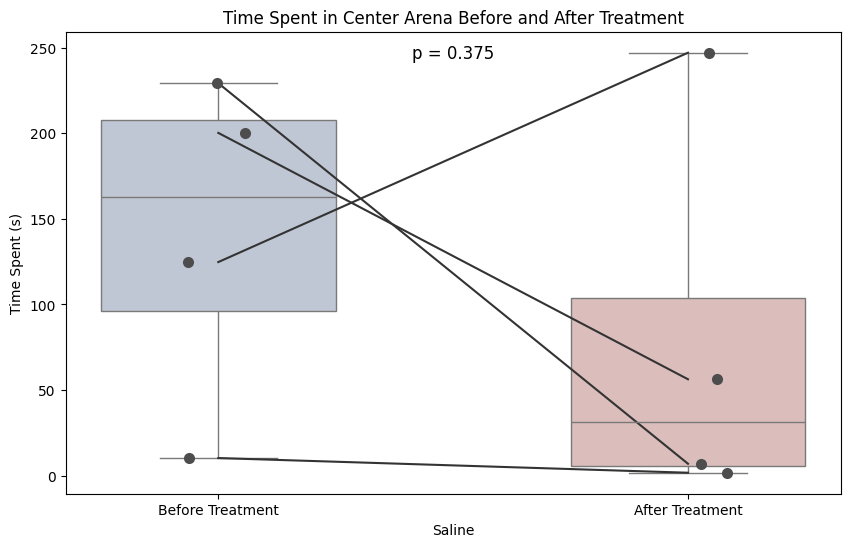

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import wilcoxon

# Data: Number of frames before and after treatment
frames_before = [307, 6877, 6006, 3742]
frames_after = [50, 207, 1688, 7411]

# Convert the number of frames to time in seconds (30 frames per second)
time_before = [frames / 30 for frames in frames_before]
time_after = [frames / 30 for frames in frames_after]

# Create a DataFrame for easier plotting
data_before_after = pd.DataFrame({
    'Time Spent': time_before + time_after,
    'Saline': ['Before Treatment'] * len(time_before) + ['After Treatment'] * len(time_after),
    'Subject': ['Animal 1', 'Animal 2', 'Animal 3', 'Animal 4'] * 2
})

# Perform Wilcoxon signed-rank test
w_statistic, p_value = wilcoxon(time_before, time_after)

# Create the box plot with data points
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Saline', y='Time Spent', data=data_before_after, width=0.5, palette="vlag")
ax = sns.stripplot(x='Saline', y='Time Spent', data=data_before_after, size=8, color=".3", linewidth=0)

# Connect the self controlled data points
for i in range(len(time_before)):
    plt.plot(['Before Treatment', 'After Treatment'], [time_before[i], time_after[i]], 'k-', color="0.2")

ax.text(0.5, max(time_before + time_after) + 5, f'p = {p_value:.3f}', 
        ha='center', va='top', color='black', fontsize=12)

plt.title('Time Spent in Center Arena Before and After Treatment')
plt.ylabel('Time Spent (s)')
plt.xlabel('Saline')
plt.show()


C:\Users\huang\AppData\Local\Temp\ipykernel_9608\1380044716.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Condition', y='Time Spent', data=data_before_after_new, width=0.5, palette="vlag")
C:\Users\huang\AppData\Local\Temp\ipykernel_9608\1380044716.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(['Before Treatment', 'After Treatment'], [time_before_new[i], time_after_new[i]], 'k-', color="0.2")


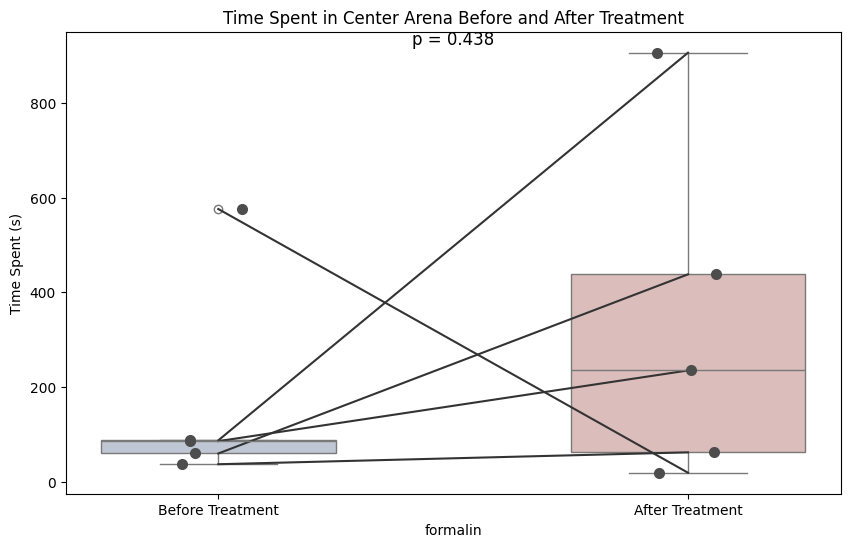

In [40]:
# New Data: Number of frames before and after treatment
frames_before_new = [17276, 1102, 2616, 1783, 2564]
frames_after_new = [564, 1855, 27181, 13136, 7045]

# Convert the number of frames to time in seconds (30 frames per second)
time_before_new = [frames / 30 for frames in frames_before_new]
time_after_new = [frames / 30 for frames in frames_after_new]

# Create a DataFrame for easier plotting
data_before_after_new = pd.DataFrame({
    'Time Spent': time_before_new + time_after_new,
    'Condition': ['Before Treatment'] * len(time_before_new) + ['After Treatment'] * len(time_after_new),
    'Subject': ['Animal 1', 'Animal 2', 'Animal 3', 'Animal 4', 'Animal 5'] * 2
})

# Perform Wilcoxon signed-rank test
w_statistic_new, p_value_new = wilcoxon(time_before_new, time_after_new)

# Create the box plot with data points
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Condition', y='Time Spent', data=data_before_after_new, width=0.5, palette="vlag")
ax = sns.stripplot(x='Condition', y='Time Spent', data=data_before_after_new, size=8, color=".3", linewidth=0)

# Connect the self controlled data points
for i in range(len(time_before_new)):
    plt.plot(['Before Treatment', 'After Treatment'], [time_before_new[i], time_after_new[i]], 'k-', color="0.2")

# Add p-value to the plot
ax.text(0.5, max(time_before_new + time_after_new) + 10, f'p = {p_value_new:.3f}', 
        ha='center', va='bottom', color='black', fontsize=12)

plt.title('Time Spent in Center Arena Before and After Treatment')
plt.ylabel('Time Spent (s)')
plt.xlabel('formalin')
plt.show()


C:\Users\huang\AppData\Local\Temp\ipykernel_10356\4284326208.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Saline', y='Time Spent', data=data_before_after, width=0.5, palette="vlag")
C:\Users\huang\AppData\Local\Temp\ipykernel_10356\4284326208.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(['Before Treatment', 'After Treatment'], [time_before[i], time_after[i]], 'k-', color="0.2")


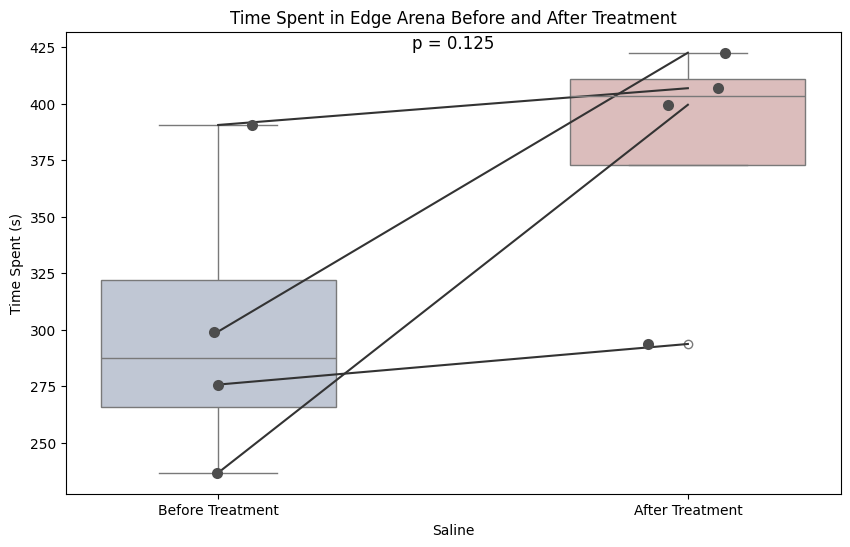

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import wilcoxon

# Data: Number of frames before and after treatment
frames_before = [11718,8976,7102,8272]
frames_after = [12206,12677,11986,8811]

# Convert the number of frames to time in seconds (30 frames per second)
time_before = [frames / 30 for frames in frames_before]
time_after = [frames / 30 for frames in frames_after]

# Create a DataFrame for easier plotting
data_before_after = pd.DataFrame({
    'Time Spent': time_before + time_after,
    'Saline': ['Before Treatment'] * len(time_before) + ['After Treatment'] * len(time_after),
    'Subject': ['Animal 1', 'Animal 2', 'Animal 3', 'Animal 4'] * 2
})

# Perform Wilcoxon signed-rank test
w_statistic, p_value = wilcoxon(time_before, time_after)

# Create the box plot with data points
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Saline', y='Time Spent', data=data_before_after, width=0.5, palette="vlag")
ax = sns.stripplot(x='Saline', y='Time Spent', data=data_before_after, size=8, color=".3", linewidth=0)

# Connect the self controlled data points
for i in range(len(time_before)):
    plt.plot(['Before Treatment', 'After Treatment'], [time_before[i], time_after[i]], 'k-', color="0.2")

ax.text(0.5, max(time_before + time_after), f'p = {p_value:.3f}', 
        ha='center', va='bottom', color='black', fontsize=12)

plt.title('Time Spent in Edge Arena Before and After Treatment')
plt.ylabel('Time Spent (s)')
plt.xlabel('Saline')
plt.show()


C:\Users\huang\AppData\Local\Temp\ipykernel_10356\3753803388.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Condition', y='Time Spent', data=data_before_after_new, width=0.5, palette="vlag")
C:\Users\huang\AppData\Local\Temp\ipykernel_10356\3753803388.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(['Before Treatment', 'After Treatment'], [time_before_new[i], time_after_new[i]], 'k-', color="0.2")


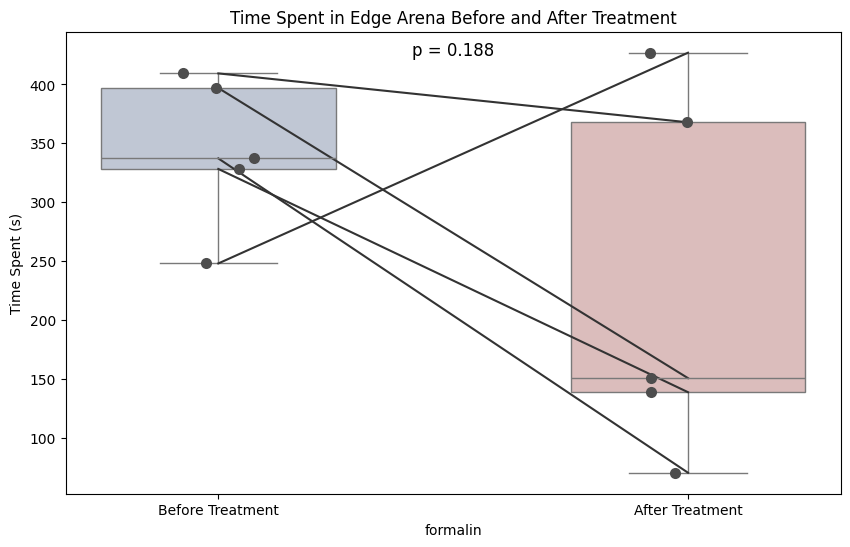

In [227]:
# New Data: Number of frames before and after treatment
frames_before_new = [7438,12283,10116,11910,9847]
frames_after_new = [12810,11036,2103,4514,4156]

# Convert the number of frames to time in seconds (30 frames per second)
time_before_new = [frames / 30 for frames in frames_before_new]
time_after_new = [frames / 30 for frames in frames_after_new]

# Create a DataFrame for easier plotting
data_before_after_new = pd.DataFrame({
    'Time Spent': time_before_new + time_after_new,
    'Condition': ['Before Treatment'] * len(time_before_new) + ['After Treatment'] * len(time_after_new),
    'Subject': ['Animal 1', 'Animal 2', 'Animal 3', 'Animal 4', 'Animal 5'] * 2
})

# Perform Wilcoxon signed-rank test
w_statistic_new, p_value_new = wilcoxon(time_before_new, time_after_new)

# Create the box plot with data points
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Condition', y='Time Spent', data=data_before_after_new, width=0.5, palette="vlag")
ax = sns.stripplot(x='Condition', y='Time Spent', data=data_before_after_new, size=8, color=".3", linewidth=0)

# Connect the self controlled data points
for i in range(len(time_before_new)):
    plt.plot(['Before Treatment', 'After Treatment'], [time_before_new[i], time_after_new[i]], 'k-', color="0.2")

# Add p-value to the plot
ax.text(0.5, max(time_before_new + time_after_new) + 10, f'p = {p_value_new:.3f}', 
        ha='center', va='top', color='black', fontsize=12)

plt.title('Time Spent in Edge Arena Before and After Treatment')
plt.ylabel('Time Spent (s)')
plt.xlabel('formalin')
plt.show()


C:\Users\huang\AppData\Local\Temp\ipykernel_10356\2014993614.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3")


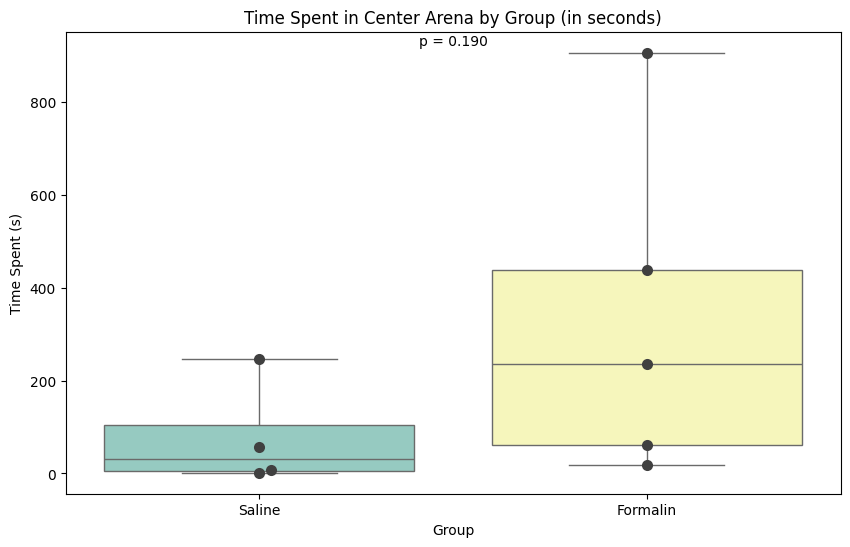

In [229]:
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu

# 1. Define the data in frames
control_group_frames = [50, 207, 1688, 7411]
pfa_group_frames = [564, 1855, 27181, 13136, 7045]

# 2. Convert frames to seconds (30 fps)
control_group_seconds = [x / 30 for x in control_group_frames]
pfa_group_seconds = [x / 30 for x in pfa_group_frames]

# 3. Create a DataFrame for easier plotting
data_seconds = pd.DataFrame({
    'Time Spent (s)': control_group_seconds + pfa_group_seconds,
    'Group': ['Saline'] * len(control_group_seconds) + ['Formalin'] * len(pfa_group_seconds)
})

# 4. Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(control_group_seconds, pfa_group_seconds)

# 5. Create the plot with individual data points
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3")
sns.swarmplot(x='Group', y='Time Spent (s)', data=data_seconds, color=".25", size=8)
plt.title('Time Spent in Center Arena by Group (in seconds)')
plt.ylabel('Time Spent (s)')
plt.xlabel('Group')

# 6. Annotate with p-value
plt.text(0.5, max(data_seconds['Time Spent (s)']) + 10, f'p = {p_value:.3f}', ha='center', va='bottom')

plt.show()



C:\Users\huang\AppData\Local\Temp\ipykernel_10356\497708533.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3")


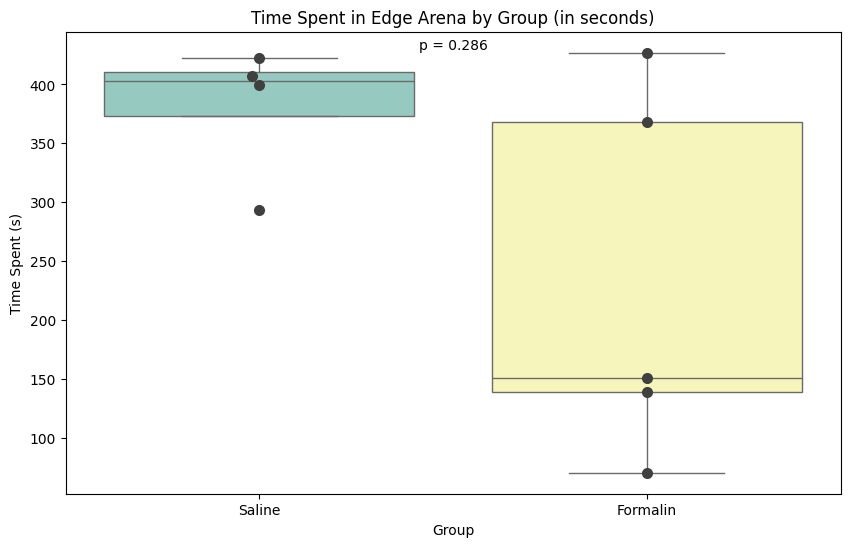

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu

# 1. Define the data in frames
control_group_frames = [12206,12677,11986,8811]
pfa_group_frames = [12810,11036,2103,4514,4156]

# 2. Convert frames to seconds (30 fps)
control_group_seconds = [x / 30 for x in control_group_frames]
pfa_group_seconds = [x / 30 for x in pfa_group_frames]

# 3. Create a DataFrame for easier plotting
data_seconds = pd.DataFrame({
    'Time Spent (s)': control_group_seconds + pfa_group_seconds,
    'Group': ['Saline'] * len(control_group_seconds) + ['Formalin'] * len(pfa_group_seconds)
})

# 4. Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(control_group_seconds, pfa_group_seconds)

# 5. Create the plot with individual data points
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3")
sns.swarmplot(x='Group', y='Time Spent (s)', data=data_seconds, color=".25", size=8)
plt.title('Time Spent in Edge Arena by Group (in seconds)')
plt.ylabel('Time Spent (s)')
plt.xlabel('Group')

# 6. Annotate with p-value
plt.text(0.5, max(data_seconds['Time Spent (s)']), f'p = {p_value:.3f}', ha='center', va='bottom')

plt.show()


## Step 4: Calculate Euclidean Distance from Reference Point

In [49]:
def calculate_total_distance(dataframes):
    # Dictionary to store the total distance for each session
    total_distance_dict = {session: 0 for session in range(len(dataframes))}
    
    for session in range(len(dataframes)):
        print(f"\nSession: {session}")
        
        if session >= len(dataframes):
            print(f"Warning: No data for session {session}. Skipping this session.")
            continue
        
        # Get points
        points = dataframes[session][['center_x', 'center_y']].values
        
        # Calculate the frame-to-frame distances
        distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
        
        # Sum the distances to get the total distance
        total_distance = np.sum(distances)
        
        # If you have a conversion factor from pixels to real-world units, apply it
        conversion_factor = 32/532  # Set the conversion factor
        total_distance_real_world = round(total_distance * conversion_factor)
        
        # Store the total distance for this session
        total_distance_dict[session] = total_distance_real_world  # or total_distance_real_world
        
    return total_distance_dict

# Usage:
total_distances_sal = calculate_total_distance(saline_dataframes)
for session, distance in total_distances_sal.items():
    #print(f'Total distance traveled in session {session}: {distance} pixels')
    print(f'Total distance traveled in session {session}: {distance} [cm]')

total_distances_pfa = calculate_total_distance(pfa_dataframes)
for session, distance in total_distances_pfa.items():
    #print(f'Total distance traveled in session {session}: {distance} pixels')
    print(f'Total distance traveled in session {session}: {distance} [cm]')



Session: 0

Session: 1

Session: 2

Session: 3

Session: 4

Session: 5

Session: 6

Session: 7
Total distance traveled in session 0: 4549 [cm]
Total distance traveled in session 1: 4277 [cm]
Total distance traveled in session 2: 4106 [cm]
Total distance traveled in session 3: 3502 [cm]
Total distance traveled in session 4: 6027 [cm]
Total distance traveled in session 5: 4936 [cm]
Total distance traveled in session 6: 4797 [cm]
Total distance traveled in session 7: 4209 [cm]

Session: 0

Session: 1

Session: 2

Session: 3

Session: 4

Session: 5

Session: 6

Session: 7

Session: 8

Session: 9
Total distance traveled in session 0: 2493 [cm]
Total distance traveled in session 1: 3070 [cm]
Total distance traveled in session 2: 3971 [cm]
Total distance traveled in session 3: 3266 [cm]
Total distance traveled in session 4: 6840 [cm]
Total distance traveled in session 5: 2454 [cm]
Total distance traveled in session 6: 3889 [cm]
Total distance traveled in session 7: 3944 [cm]
Total distance t

C:\Users\huang\AppData\Local\Temp\ipykernel_9608\4048370256.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\Temp\ipykernel_9608\4048370256.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\Temp\ipykernel_9608\4048370256.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.barplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3", capsize=0.1, errwidth=2, ci='sd')


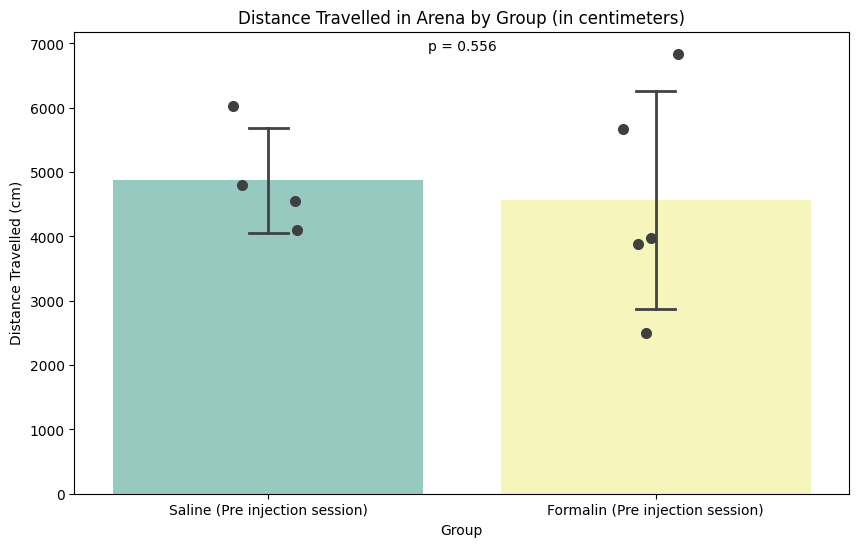

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np

# 1. Define the data in frames
control_group_frames = [4549,4106,6027,4797]
pfa_group_frames = [2493,3971,6840,3889,5663]

# 2. Convert frames to seconds (30 fps)
control_group_seconds = [x for x in control_group_frames]
pfa_group_seconds = [x for x in pfa_group_frames]

# 3. Create a DataFrame for easier plotting
data_seconds = pd.DataFrame({
    'Time Spent (s)': control_group_seconds + pfa_group_seconds,
    'Group': ['Saline (Pre injection session)'] * len(control_group_seconds) + ['Formalin (Pre injection session)'] * len(pfa_group_seconds)
})

# 4. Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(control_group_seconds, pfa_group_seconds)

# 5. Create the plot with mean +/- sd
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3", capsize=0.1, errwidth=2, ci='sd')
sns.stripplot(x='Group', y='Time Spent (s)', data=data_seconds, color=".25", size=8, jitter=True)
plt.title('Distance Travelled in Arena by Group (in centimeters)')
plt.ylabel('Distance Travelled (cm)')
plt.xlabel('Group')

# 6. Annotate with p-value
plt.text(0.5, max(data_seconds['Time Spent (s)']), f'p = {p_value:.3f}', ha='center', va='bottom')

plt.show()


C:\Users\huang\AppData\Local\Temp\ipykernel_9608\525929503.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\Temp\ipykernel_9608\525929503.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\Temp\ipykernel_9608\525929503.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.barplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3", capsize=0.1, errwidth=2, ci='sd')


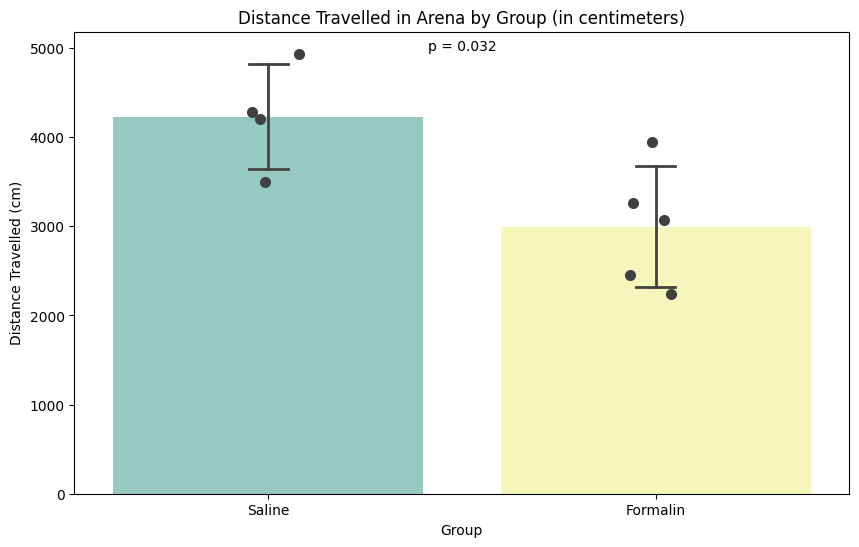

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np

# 1. Define the data in frames
control_group_frames = [4277,3502,4936,4209]
pfa_group_frames = [3070,3266,2454,3944,2244]

# 2. Convert frames to seconds (30 fps)
control_group_seconds = [x for x in control_group_frames]
pfa_group_seconds = [x for x in pfa_group_frames]

# 3. Create a DataFrame for easier plotting
data_seconds = pd.DataFrame({
    'Time Spent (s)': control_group_seconds + pfa_group_seconds,
    'Group': ['Saline'] * len(control_group_seconds) + ['Formalin'] * len(pfa_group_seconds)
})

# 4. Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(control_group_seconds, pfa_group_seconds)

# 5. Create the plot with mean +/- sd
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3", capsize=0.1, errwidth=2, ci='sd')
sns.stripplot(x='Group', y='Time Spent (s)', data=data_seconds, color=".25", size=8, jitter=True)
plt.title('Distance Travelled in Arena by Group (in centimeters)')
plt.ylabel('Distance Travelled (cm)')
plt.xlabel('Group')

# 6. Annotate with p-value
plt.text(0.5, max(data_seconds['Time Spent (s)']), f'p = {p_value:.3f}', ha='center', va='bottom')

plt.show()


C:\Users\huang\AppData\Local\Temp\ipykernel_9608\3538451421.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(x='Saline', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\Temp\ipykernel_9608\3538451421.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Saline', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\Temp\ipykernel_9608\3538451421.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.barplot(x='Saline', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\

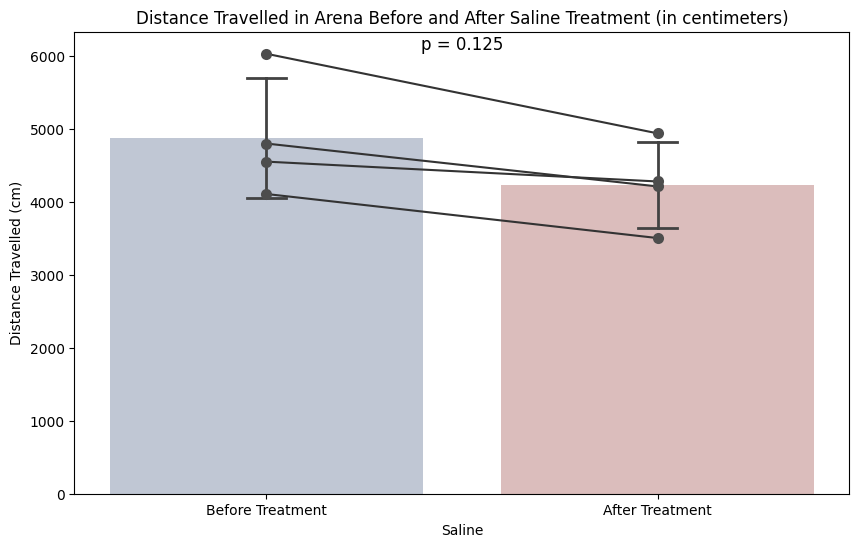

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import wilcoxon

# Data: Number of frames before and after treatment
frames_before = [4549,4106,6027,4797]
frames_after = [4277,3502,4936,4209]

# Convert the number of frames to time in seconds (30 frames per second)
time_before = [frames for frames in frames_before]
time_after = [frames for frames in frames_after]

# Create a DataFrame for easier plotting
data_before_after = pd.DataFrame({
    'Time Spent': time_before + time_after,
    'Saline': ['Before Treatment'] * len(time_before) + ['After Treatment'] * len(time_after),
    'Subject': ['Animal 1', 'Animal 2', 'Animal 3', 'Animal 4'] * 2
})

# Perform Wilcoxon signed-rank test
w_statistic, p_value = wilcoxon(time_before, time_after)

# Create the bar plot with mean +/- sd and data points
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Saline', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
ax = sns.stripplot(x='Saline', y='Time Spent', data=data_before_after, size=8, color=".3", linewidth=0, dodge=False, jitter=False)

# Connect the self controlled data points
for i in range(len(time_before)):
    plt.plot(['Before Treatment', 'After Treatment'], [time_before[i], time_after[i]], 'k-', color="0.2")

ax.text(0.5, max(time_before + time_after), f'p = {p_value:.3f}', 
        ha='center', va='bottom', color='black', fontsize=12)

plt.title('Distance Travelled in Arena Before and After Saline Treatment (in centimeters)')
plt.ylabel('Distance Travelled (cm)')
plt.xlabel('Saline')
plt.show()


C:\Users\huang\AppData\Local\Temp\ipykernel_9608\102549844.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(x='Saline', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\Temp\ipykernel_9608\102549844.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Saline', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\Temp\ipykernel_9608\102549844.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.barplot(x='Saline', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\Tem

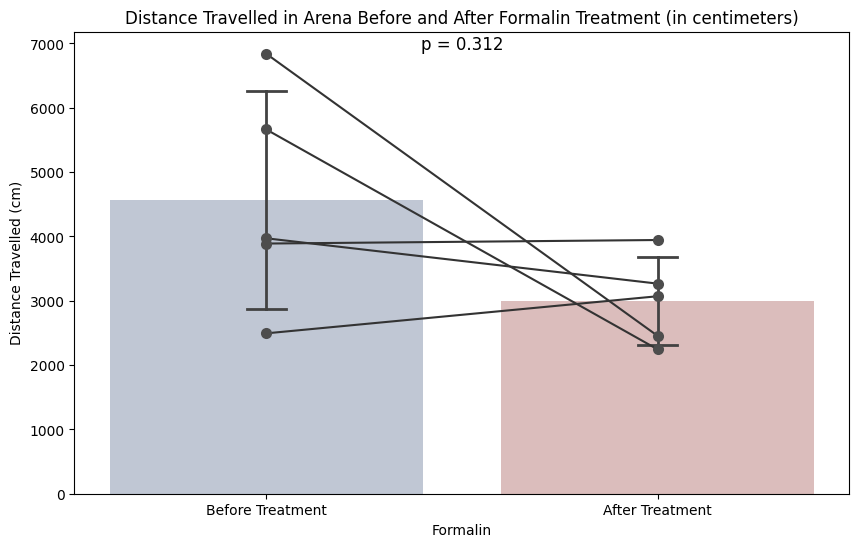

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import wilcoxon

# Data: Number of frames before and after treatment
frames_before = [2493,3971,6840,3889,5663]
frames_after = [3070,3266,2454,3944,2244]

# Convert the number of frames to time in seconds (30 frames per second)
time_before = [frames for frames in frames_before]
time_after = [frames for frames in frames_after]

# Create a DataFrame for easier plotting
data_before_after = pd.DataFrame({
    'Time Spent': time_before + time_after,
    'Saline': ['Before Treatment'] * len(time_before) + ['After Treatment'] * len(time_after),
    'Subject': ['Animal 1', 'Animal 2', 'Animal 3', 'Animal 4', 'Animal 5'] * 2
})

# Perform Wilcoxon signed-rank test
w_statistic, p_value = wilcoxon(time_before, time_after)

# Create the bar plot with mean +/- sd and data points
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Saline', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
ax = sns.stripplot(x='Saline', y='Time Spent', data=data_before_after, size=8, color=".3", linewidth=0, dodge=False, jitter=False)

# Connect the self controlled data points
for i in range(len(time_before)):
    plt.plot(['Before Treatment', 'After Treatment'], [time_before[i], time_after[i]], 'k-', color="0.2")

ax.text(0.5, max(time_before + time_after), f'p = {p_value:.3f}', 
        ha='center', va='bottom', color='black', fontsize=12)

plt.title('Distance Travelled in Arena Before and After Formalin Treatment (in centimeters)')
plt.ylabel('Distance Travelled (cm)')
plt.xlabel('Formalin')
plt.show()


# Velocity Calculation

In [36]:
def calculate_velocity(dataframes):
    velocity_dict = {session: [] for session in range(len(dataframes))}
    
    for session in range(len(dataframes)):
        print(f"\nSession: {session}")
        
        if session >= len(dataframes):
            print(f"Warning: No data for session {session}. Skipping this session.")
            continue
        
        # Get points
        points = dataframes[session][['center_x', 'center_y']].values
        
        # Calculate the frame-to-frame distances
        distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
        
        # Time between frames in seconds (assuming 30 fps)
        delta_t = 1 / 30
        
        # Calculate velocities
        velocities = distances / delta_t
        
        # Store the velocities for this session
        velocity_dict[session] = velocities
        
    return velocity_dict

# Usage:
velocities = calculate_velocity(saline_dataframes)
for session, velocity in velocities.items():
    print(f'Velocity in session {session}: {velocity} pixels per second')



Session: 0

Session: 1

Session: 2

Session: 3

Session: 4

Session: 5

Session: 6

Session: 7
Velocity in session 0: [2.52404314e+00 2.10335508e+00 7.32421875e-03 ... 1.63774510e-02
 8.34563512e+00 2.08110401e+01] pixels per second
Velocity in session 1: [7.34269212e+01 8.31664072e+01 2.39889553e+00 ... 3.43451990e+00
 2.04718138e-03 8.31136872e+00] pixels per second
Velocity in session 2: [ 2.81614127  2.08767859  1.49793732 ... 26.15289912  9.2112551
  8.34854104] pixels per second
Velocity in session 3: [2.21201074e+00 1.32873773e+00 1.17244706e-02 ... 3.28857881e-02
 8.05717853e+01 1.85499661e+02] pixels per second
Velocity in session 4: [ 17.07892867  45.80732253  67.33953023 ...  92.77554873 120.88505484
  43.98992533] pixels per second
Velocity in session 5: [ 23.30679134 126.08981771 103.66745183 ...  10.38143116   0.14208383
   4.01040532] pixels per second
Velocity in session 6: [2.22369863e+01 1.64794922e-02 1.99432092e+01 ... 1.67415961e+01
 2.29697141e+01 1.24307483e+01]


Session: 0

Session: 1

Session: 2

Session: 3

Session: 4

Session: 5

Session: 6

Session: 7


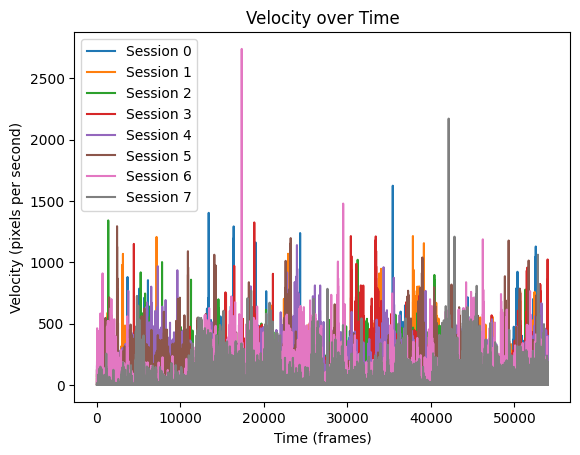


Session: 0

Session: 1

Session: 2

Session: 3

Session: 4

Session: 5

Session: 6

Session: 7


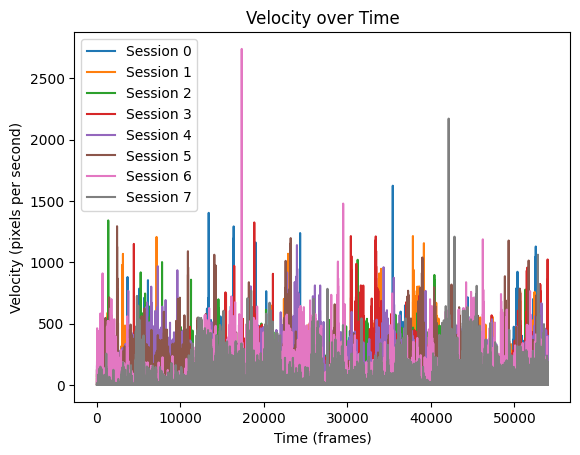

In [48]:
from scipy.signal import savgol_filter

def calculate_velocity_smooth(dataframes):
    velocity_dict = {session: [] for session in range(len(dataframes))}
    
    for session in range(len(dataframes)):
        print(f"\nSession: {session}")
        
        if session >= len(dataframes):
            print(f"Warning: No data for session {session}. Skipping this session.")
            continue
        
        # Get points
        points = dataframes[session][['center_x', 'center_y']].values
        
        # Calculate the frame-to-frame distances
        distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
        
        # Time between frames in seconds (assuming 30 fps)
        delta_t = 1 / 30
        
        # Calculate velocities
        velocities = distances / delta_t
        
        # Smooth velocities using savgol_filter
        smoothed_velocities = savgol_filter(velocities, 11, 1)
        
        # Store the velocities for this session
        velocity_dict[session] = smoothed_velocities
        
    return velocity_dict

# Calculate velocities
velocities = calculate_velocity(saline_dataframes)

# Plot velocities for each session
for session, velocity in velocities.items():
    plt.plot(velocity, label=f'Session {session}')

plt.title('Velocity over Time')
plt.xlabel('Time (frames)')
plt.ylabel('Velocity (pixels per second)')
plt.legend()
plt.show()


In [49]:
import plotly.graph_objs as go

# Create a trace for the velocity data
trace = go.Scatter(x=list(range(len(velocity))), y=velocity, name='Velocity')

# Create the layout with zooming functionality
layout = go.Layout(title='Velocity over Time', xaxis=dict(title='Time (frames)'), yaxis=dict(title='Velocity (pixels per second)'), hovermode='closest', uirevision='true', xaxis_rangeslider_visible=True)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Display the figure
fig.show()


In [59]:
def calculate_avg_speed(dataframes):
    avg_speed_dict = {session: 0 for session in range(len(dataframes))}
    
    for session in range(len(dataframes)):
        print(f"\nSession: {session}")
        
        if session >= len(dataframes):
            print(f"Warning: No data for session {session}. Skipping this session.")
            continue
        
        # Get points
        points = dataframes[session][['center_x', 'center_y']].values
        
        # Calculate the frame-to-frame distances
        distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
        
        # Time between frames in seconds (assuming 30 fps)
        delta_t = 1 / 30
        
        # Calculate velocities
        velocities = distances / delta_t
        
        # Calculate the average velocity for this session
        avg_speed = np.mean(velocities)
        avg_speed_real = avg_speed *32 / 532
        
        # Store the average velocity for this session
        avg_speed_dict[session] = avg_speed_real
        
    return avg_speed_dict

# Usage:
avg_speeds = calculate_avg_speed(saline_dataframes)
for session, avg_speed in avg_speeds.items():
    print(f'Average speed in session {session}: {avg_speed:.2f} cm per second')



Session: 0

Session: 1

Session: 2

Session: 3

Session: 4

Session: 5

Session: 6

Session: 7
Average speed in session 0: 2.53 cm per second
Average speed in session 1: 2.38 cm per second
Average speed in session 2: 2.28 cm per second
Average speed in session 3: 1.95 cm per second
Average speed in session 4: 3.35 cm per second
Average speed in session 5: 2.74 cm per second
Average speed in session 6: 2.66 cm per second
Average speed in session 7: 2.34 cm per second


In [60]:
def calculate_avg_speed(dataframes):
    avg_speed_dict = {session: 0 for session in range(len(dataframes))}
    
    for session in range(len(dataframes)):
        print(f"\nSession: {session}")
        
        if session >= len(dataframes):
            print(f"Warning: No data for session {session}. Skipping this session.")
            continue
        
        # Get points
        points = dataframes[session][['center_x', 'center_y']].values
        
        # Calculate the frame-to-frame distances
        distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
        
        # Time between frames in seconds (assuming 30 fps)
        delta_t = 1 / 30
        
        # Calculate velocities
        velocities = distances / delta_t
        
        # Calculate the average velocity for this session
        avg_speed = np.mean(velocities)
        avg_speed_real = avg_speed *32 / 532
        
        # Store the average velocity for this session
        avg_speed_dict[session] = avg_speed_real
        
    return avg_speed_dict

# Usage:
avg_speeds = calculate_avg_speed(pfa_dataframes)
for session, avg_speed in avg_speeds.items():
    print(f'Average speed in session {session}: {avg_speed:.2f} cm per second')



Session: 0

Session: 1

Session: 2

Session: 3

Session: 4

Session: 5

Session: 6

Session: 7

Session: 8

Session: 9
Average speed in session 0: 1.38 cm per second
Average speed in session 1: 1.71 cm per second
Average speed in session 2: 2.21 cm per second
Average speed in session 3: 1.81 cm per second
Average speed in session 4: 3.80 cm per second
Average speed in session 5: 1.36 cm per second
Average speed in session 6: 2.16 cm per second
Average speed in session 7: 2.19 cm per second
Average speed in session 8: 3.15 cm per second
Average speed in session 9: 1.25 cm per second


C:\Users\huang\AppData\Local\Temp\ipykernel_956\994072376.py:26: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.


C:\Users\huang\AppData\Local\Temp\ipykernel_956\994072376.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\huang\AppData\Local\Temp\ipykernel_956\994072376.py:26: FutureWarning:



The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.




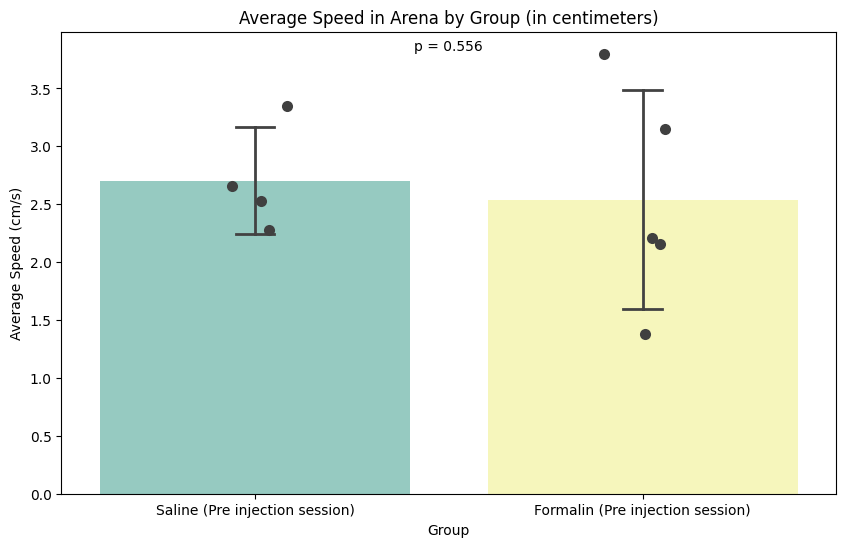

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np

# 1. Define the data in frames
control_group_frames = [2.53, 2.28, 3.35, 2.66]
pfa_group_frames = [1.38 , 2.21, 3.80, 2.16, 3.15]

# 2. Convert frames to seconds (30 fps)
control_group_seconds = [x for x in control_group_frames]
pfa_group_seconds = [x for x in pfa_group_frames]

# 3. Create a DataFrame for easier plotting
data_seconds = pd.DataFrame({
    'Time Spent (s)': control_group_seconds + pfa_group_seconds,
    'Group': ['Saline (Pre injection session)'] * len(control_group_seconds) + ['Formalin (Pre injection session)'] * len(pfa_group_seconds)
})

# 4. Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(control_group_seconds, pfa_group_seconds)

# 5. Create the plot with mean +/- sd
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3", capsize=0.1, errwidth=2, ci='sd')
sns.stripplot(x='Group', y='Time Spent (s)', data=data_seconds, color=".25", size=8, jitter=True)
plt.title('Average Speed in Arena by Group (in centimeters)')
plt.ylabel('Average Speed (cm/s)')
plt.xlabel('Group')

# 6. Annotate with p-value
plt.text(0.5, max(data_seconds['Time Spent (s)']), f'p = {p_value:.3f}', ha='center', va='bottom')

plt.show()


C:\Users\huang\AppData\Local\Temp\ipykernel_956\2203147697.py:26: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.


C:\Users\huang\AppData\Local\Temp\ipykernel_956\2203147697.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\huang\AppData\Local\Temp\ipykernel_956\2203147697.py:26: FutureWarning:



The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.




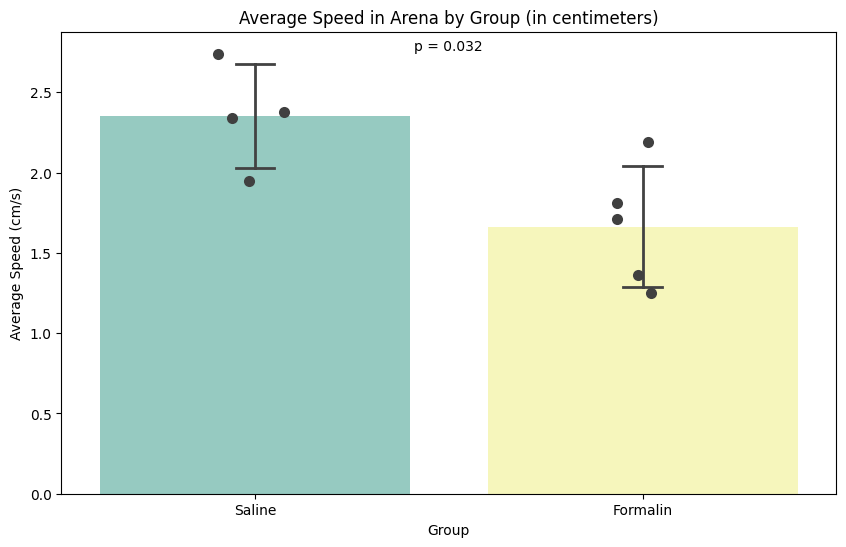

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np

# 1. Define the data in frames
control_group_frames = [2.38 , 1.95, 2.74, 2.34]
pfa_group_frames = [1.71,1.81,1.36,2.19,1.25]

# 2. Convert frames to seconds (30 fps)
control_group_seconds = [x for x in control_group_frames]
pfa_group_seconds = [x for x in pfa_group_frames]

# 3. Create a DataFrame for easier plotting
data_seconds = pd.DataFrame({
    'Time Spent (s)': control_group_seconds + pfa_group_seconds,
    'Group': ['Saline'] * len(control_group_seconds) + ['Formalin'] * len(pfa_group_seconds)
})

# 4. Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(control_group_seconds, pfa_group_seconds)

# 5. Create the plot with mean +/- sd
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3", capsize=0.1, errwidth=2, ci='sd')
sns.stripplot(x='Group', y='Time Spent (s)', data=data_seconds, color=".25", size=8, jitter=True)
plt.title('Average Speed in Arena by Group (in centimeters)')
plt.ylabel('Average Speed (cm/s)')
plt.xlabel('Group')

# 6. Annotate with p-value
plt.text(0.5, max(data_seconds['Time Spent (s)']), f'p = {p_value:.3f}', ha='center', va='bottom')

plt.show()


## Step 5: Apply PCA for Dimensionality Reduction (Optional, but can speed up t-SNE)

In [49]:
all_data_distance = pd.concat([pd.concat(saline_data_distance), pd.concat(pfa_data_distance)], axis=0)

# Ensure n_components is less than or equal to min(n_samples, n_features)
# n_components = min(50, all_data_distance.shape[0], all_data_distance.shape[1])
n_components = 2

pca = PCA(n_components=n_components)  
data_pca = pca.fit_transform(all_data_distance)


(511209, 2)


<function matplotlib.pyplot.show(close=None, block=None)>

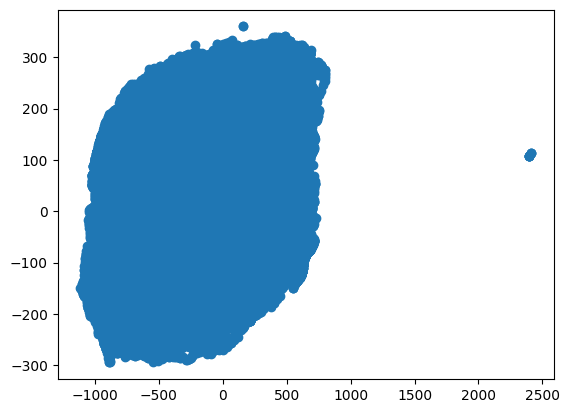

In [53]:
print(np.shape(data_pca))
plt.scatter(data_pca[:,0], data_pca[:,1])
plt.show

## Step 6: Apply t-SNE for Visualization

In [54]:
tsne = TSNE(n_components=2, perplexity=200)
data_tsne = tsne.fit_transform(all_data_distance)

plt.figure(figsize=(10, 6))
plt.scatter(data_tsne[:len(pd.concat(saline_data_distance)), 0], 
            data_tsne[:len(pd.concat(saline_data_distance)), 1], 
            marker='o', color='red', alpha=0.7, label='saline')
plt.scatter(data_tsne[len(pd.concat(saline_data_distance)):, 0], 
            data_tsne[len(pd.concat(saline_data_distance)):, 1], 
            marker='s', color='blue', alpha=0.7, label='pfa')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper right')
plt.title('t-SNE Visualization of Euclidean Distance Representation')
plt.grid(True)
plt.show()


KeyboardInterrupt: 

## Step 7: Apply UMAP for Visualization

In [29]:
reducer = umap.UMAP(random_state=42)
data_umap = reducer.fit_transform(data_pca)

plt.figure(figsize=(10, 6))
plt.scatter(data_umap[:len(pd.concat(saline_data_distance)), 0], 
            data_umap[:len(pd.concat(saline_data_distance)), 1], 
            marker='o', color='red', alpha=0.7, label='saline')
plt.scatter(data_umap[len(pd.concat(saline_data_distance)):, 0], 
            data_umap[len(pd.concat(saline_data_distance)):, 1], 
            marker='s', color='blue', alpha=0.7, label='pfa')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(loc='upper right')
plt.title('UMAP Visualization of Euclidean Distance Representation')
plt.grid(True)
plt.show()

C:\Users\huang\AppData\Local\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\huang\AppData\Local\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 